In [1]:
import config
from itertools import cycle
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, RandomSampler

from model import MHA_LSTM

In [2]:
input = torch.randn(4, 40, 1000)

model = MHA_LSTM()

seq_pred, mm_pred = model(input)

seq_pred.shape, mm_pred.shape

(torch.Size([4, 3, 1000]), torch.Size([4, 2]))

In [3]:
from dataset import train_dataset, val_dataset, unlabeled_dataset


Training with 751 patients!



/opt/conda/lib/python3.10/site-packages/torch/functional.py:641: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/aten/src/ATen/native/SpectralOps.cpp:862.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


In [4]:
import config

from train_validate_test import collate_fn

sampler_unlabeled = RandomSampler(unlabeled_dataset, replacement=True)

train_dataloader = DataLoader(train_dataset, batch_size= config.strong_bs, shuffle=True, collate_fn= collate_fn, num_workers=config.num_workers)
unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size= config.unlabel_bs, sampler= sampler_unlabeled, collate_fn= collate_fn, num_workers=config.num_workers)
val_dataloader = DataLoader(val_dataset, batch_size= config.val_bs, shuffle=False,  collate_fn= collate_fn, num_workers=config.num_workers) 

In [5]:
len(train_dataloader), len(unlabeled_dataloader)

(25, 4)

In [6]:
for i, (batch_strong, batch_unlabel) in enumerate(zip(train_dataloader, cycle(unlabeled_dataloader))):
    
    print(i)
    
    str_mels, str_seq_labels, str_pad_masks, str_mm_labels, _, _ = batch_strong
    ul_mels, ul_seq_labels, ul_pad_masks, ul_mm_labels, _, _ = batch_unlabel
    
    batch_mels = torch.concat([str_mels, ul_mels], dim= 0)
    batch_seq_labels = torch.concat([str_seq_labels, ul_seq_labels], dim= 0)
    batch_pad_masks = torch.concat([str_pad_masks, ul_pad_masks], dim= 0)
    batch_mm_labels = torch.concat([str_mm_labels, ul_mm_labels], dim= 0)
    
    
    seq_pred_stu, mm_pred_stu = model(batch_mels, batch_pad_masks)
    
    seq_pred_stu, mm_pred_stu = F.sigmoid(seq_pred_stu), F.softmax(mm_pred_stu, dim= -1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


KeyboardInterrupt: 

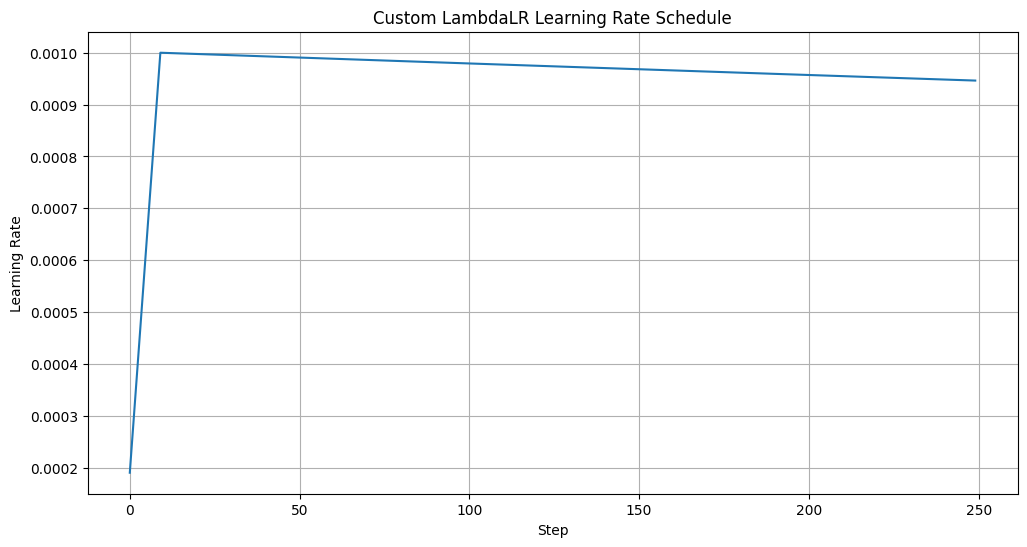

In [1]:
import math
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt

import config


def create_custom_lambda_scheduler(optimizer, base_lr=1e-4, max_lr=0.001, final_lr=1e-6,
                                   total_epochs=250, steps_per_epoch=23,
                                   max_epoch=10, decay_rate=None):

    total_steps = total_epochs * steps_per_epoch
    max_step = max_epoch * steps_per_epoch

    if decay_rate is None:
        # 자동으로 decay_rate 계산
        # final_lr = max_lr * exp(-decay_rate * (total_steps - max_step))
        decay_rate = math.log(max_lr / final_lr) / (total_steps - max_step)
    
    def lr_lambda(step):
        if step < max_step:
            # 선형 증가: base_lr -> max_lr
            return 1 + (max_lr / base_lr - 1) * (step / max_step)
        else:
            # 지수적 감소: max_lr -> final_lr
            return (max_lr / base_lr) * math.exp(-decay_rate * (step - max_step))
    
    return LambdaLR(optimizer, lr_lambda=lr_lambda)

# 모델 및 옵티마이저 정의 (예시)
model = torch.nn.Linear(10, 2)
optimizer = optim.SGD(model.parameters(), lr= config.learning_rate)  # base_lr 설정

# 커스텀 LambdaLR 스케줄러 생성
scheduler = create_custom_lambda_scheduler(
    optimizer=optimizer,
    base_lr= config.learning_rate,
    max_lr= config.max_lr,
    final_lr= config.final_lr,
    total_epochs= config.max_epoch,
    steps_per_epoch= 23,
    max_epoch= config.pct_start,
    decay_rate= 1e-5  #config.lambda_sch_decay_rate # 1e-3 기본값으로 자동 계산
)

# 학습률 기록을 위한 리스트
lrs = []

# 학습 루프 (예시)
total_epochs = 250
steps_per_epoch = 23

for epoch in range(total_epochs):
    for batch in range(steps_per_epoch):
        # 예시 학습 단계
        optimizer.zero_grad()
        inputs = torch.randn(32, 10)
        targets = torch.randint(0, 2, (32,))
        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # 현재 학습률 기록
    current_lr = optimizer.param_groups[0]['lr']
    lrs.append(current_lr)

# 학습률 그래프 시각화
plt.figure(figsize=(12, 6))
plt.plot(lrs)
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title('Custom LambdaLR Learning Rate Schedule')
plt.grid(True)
plt.show()


In [6]:
torch.randn(4,10).sum(dim=-1).shape

torch.Size([4])